In [1]:
import math
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [2]:
import pathlib
image_dir = 'data'
image_dir = pathlib.Path(image_dir)

In [3]:
image_list = list(image_dir.glob('images/*.png'))
len(image_list)

21551

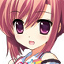

In [4]:
PIL.Image.open(image_list[0])

In [5]:
BATCH_SIZE = 128
IMG_HEIGHT = IMG_WIDTH = 64

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    label_mode=None,
    validation_split=0.2,
    subset='training',
    seed=0,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    label_mode=None,
    validation_split=0.2,
    subset='validation',
    seed=0,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 21551 files belonging to 1 classes.
Using 17241 files for training.
Found 21551 files belonging to 1 classes.
Using 4310 files for validation.


In [7]:
train_ds = train_ds.map(lambda x : x/255)
val_ds = val_ds.map(lambda x : x/255)

In [8]:
sample_images = next(iter(train_ds))[:16]

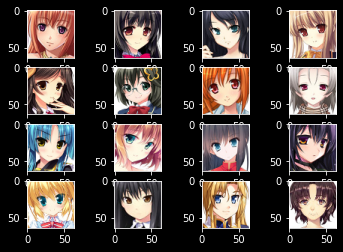

In [13]:
import matplotlib.pyplot as plt
plt.figure()
for i, image in enumerate(sample_images):
    plt.subplot(4, 4, i+1)
    plt.imshow(image.numpy())

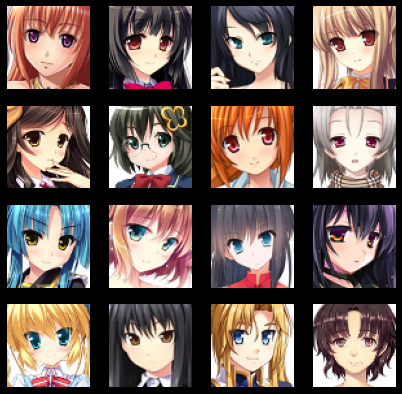

In [10]:
plt.figure(figsize=(7, 7))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    plt.imshow(sample_images[i].numpy())
plt.savefig('sample_image.png')

In [11]:
sample_images.shape

TensorShape([16, 64, 64, 3])

In [12]:
from model import *
encoder = Encoder(64)

In [13]:
latent = encoder(sample_images)
print(latent.shape)

(16, 128)


In [14]:
mean, logvar = tf.split(latent, num_or_size_splits=2, axis=1)
print(mean.shape, logvar.shape)

(16, 64) (16, 64)


In [15]:
eps = tf.random.normal(shape=mean.shape)
latent = eps*tf.exp(logvar*0.5)+mean
print(latent.shape)

(16, 64)


In [16]:
decoder = Decoder()

In [17]:
decoder(latent).shape

TensorShape([16, 64, 64, 3])

In [18]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  log_normal = -0.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)
  return tf.reduce_sum(log_normal, axis=raxis)

In [19]:
def compute_loss(model, x, kl_factor=1.):
  mean, logvar = model.encode(x)
  z = model.compute_latent(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  kl_term = kl_factor * (logpz - logqz_x)
  return -tf.reduce_mean(logpx_z + kl_term)

In [20]:
epochs = 100
num_examples_to_generate = 16
latent_dim = 256
save_interval = 5

model = VAE(latent_dim)
model_id = f'dim_{model.latent_dim}'

In [21]:
optimizer = tf.optimizers.Adam(1e-4)

In [22]:
output_dir = 'output'
checkpoint_path = os.path.join(output_dir, 'checkpoints', model_id)
log_dir = os.path.join(output_dir, 'logs', model_id)
images_save_dir = os.path.join(output_dir, 'images', model_id)

train_loss = tf.keras.metrics.Mean(name='train_ELBO')
val_loss = tf.keras.metrics.Mean(name='val_ELBO')
summary_writer = tf.summary.create_file_writer(log_dir)
tf.summary.trace_on(graph=True, profiler=False)

ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [23]:
random_vector_for_generation = tf.random.normal(shape=(num_examples_to_generate, model.latent_dim))

In [24]:
@tf.function
def train_step(model, x):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)

@tf.function
def val_step(model, x):
    loss = compute_loss(model, x)

    val_loss(loss)

In [25]:
image = next(iter(train_ds))
model(image)

with summary_writer.as_default():
    func_graph = val_step.get_concrete_function(model, image).graph
    tf.python.ops.summary_ops_v2.graph(func_graph.as_graph_def(), step=0)

model.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  3305024   
_________________________________________________________________
decoder_1 (Decoder)          multiple                  2198467   
Total params: 5,503,491
Trainable params: 5,503,491
Non-trainable params: 0
_________________________________________________________________


In [26]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    latent = model.compute_latent(mean, logvar)
    predictions = model.decode(latent, apply_sigmoid=True)

    fig=plt.figure(figsize=(7, 7))
    num_of_images = predictions.shape[0]
    egde_len = math.ceil(math.sqrt(num_of_images))
    for i in range(num_of_images):
        plt.subplot(egde_len, egde_len, i+1)
        plt.imshow(predictions[i])
    plt.savefig(os.path.join(images_save_dir, f'epoch_{epoch}.png'))
    plt.show()

In [27]:
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    last_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1]) * 5
    print(f'Read checkpoint, {last_epoch} epoches have beed trained.')
else:
    last_epoch = 0
    print('Checkpoint not found.')

Read checkpoint, 100 epoches have beed trained.


In [27]:
iter_len = tf.data.experimental.cardinality(train_ds).numpy()
print(f'iter_len: {iter_len}')

iter_len: 135


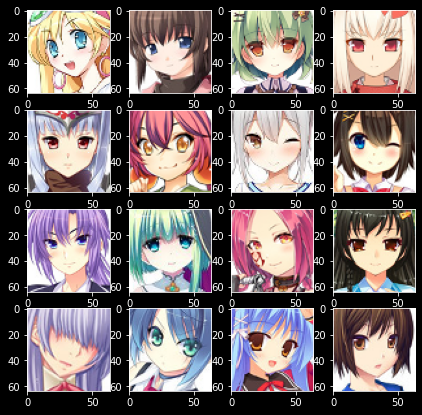

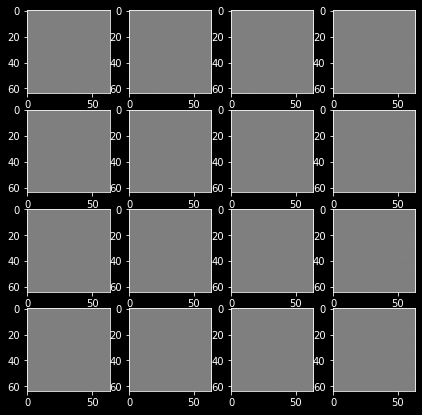

In [28]:
generate_and_save_images(model, 0, sample_images)

135/135 [==============================] - 11s 82ms/step


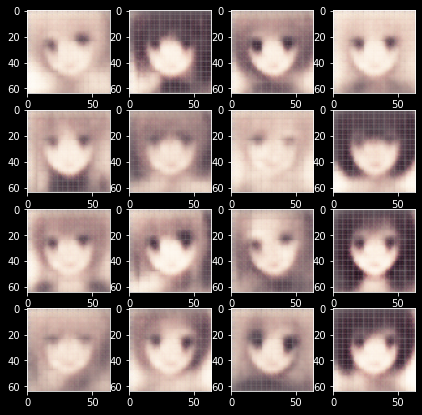

135/135 [==============================] - 12s 89ms/step


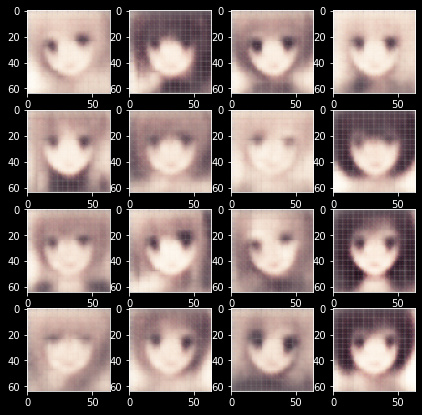

135/135 [==============================] - 13s 94ms/step


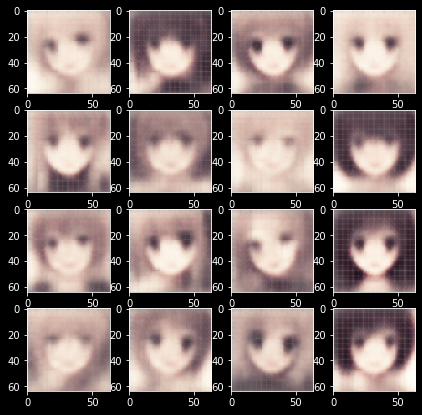

135/135 [==============================] - 12s 91ms/step


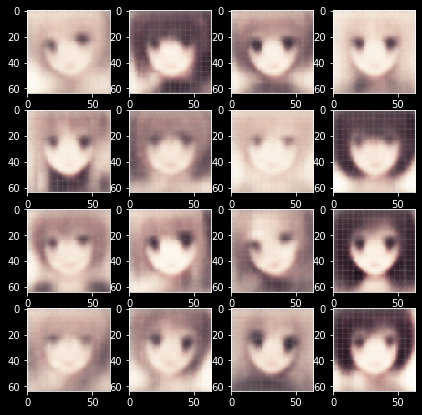

135/135 [==============================] - 12s 91ms/step


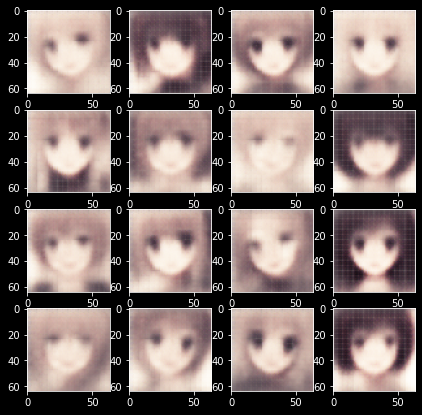

Save checkpoint for epoch 5 at output\checkpoints\dim_16\ckpt-3.


ValueError: Attempt to convert a value (<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=504x504 at 0x26908CD6B88>) with an unsupported type (<class 'PIL.PngImagePlugin.PngImageFile'>) to a Tensor.

In [32]:
for epoch in range(1, epochs+1):
    train_loss.reset_states()
    val_loss.reset_states()

    probar = tf.keras.utils.Progbar(iter_len)

    for train_x in train_ds:
        train_step(model, train_x)
        probar.add(1)
    
    for val_x in val_ds:
        val_step(model, val_x)

    generate_and_save_images(model, epoch, sample_images)

    if epoch % save_interval == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Save checkpoint for epoch {epoch} at {ckpt_save_path}.')

    with summary_writer.as_default():
        tf.summary.scalar('train_ELBO', train_loss.result(), step=epoch)
        tf.summary.scalar('val_ELBO', val_loss.result(), step=epoch)